 # Chargement des librairies

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import keras
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model, Input, Model
from keras.layers import Dense, Dropout, UpSampling2D, Activation, Flatten, Lambda, Reshape
from keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, AveragePooling2D
from keras.layers import Concatenate, Add, Multiply, Reshape, Dot
from keras.layers import LSTM

from keras.callbacks import TensorBoard

from keras.datasets import mnist

import numpy as np
import os, shutil, sys
import imageio
import random
import matplotlib.pyplot as plt
from matplotlib import cm
import statistics
import datetime
import time
import spectral.io.envi as envi
import imageio

from sklearn.svm import SVC

Using TensorFlow backend.


# Base de donnée MNIST

In [2]:
(x_train_t, y_train), (x_test_t, y_test) = mnist.load_data()

N1=x_train_t.shape[0]
N2=x_test_t.shape[0]
I=x_train_t.shape[1]
J=x_train_t.shape[2]

x_train=np.zeros((N1,I,J,1))
x_test=np.zeros((N2,I,J,1))

x_train[:,:,:,0]=x_train_t/255.0
x_test[:,:,:,0]=x_test_t/255.0

num_classes=np.max(y_train)+1

y_train_class=keras.utils.to_categorical(y_train, num_classes=num_classes)
y_test_class=keras.utils.to_categorical(y_test, num_classes=num_classes)

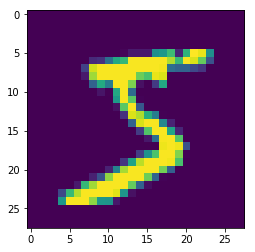

5


In [3]:
id_sample=0

plt.imshow(x_train[id_sample,:,:,0])
plt.show()

print(y_train[id_sample])

In [4]:
print("Train shape:")
print(x_train.shape)
print(y_train.shape)
print("Test shape:")
print(x_test.shape)
print(y_test.shape)

Train shape:
(60000, 28, 28, 1)
(60000,)
Test shape:
(10000, 28, 28, 1)
(10000,)


# Modèles

In [5]:
I=x_train.shape[1]
J=x_train.shape[2]
L=x_train.shape[3]

encoding_dim = 20

I1=Input(shape=(I,J,L),name="Input1")
F=Flatten(name="Flatten")(I1)
encoder=Dense(encoding_dim)(F)
A1=Activation("relu")(encoder)

A2=Dense(num_classes,activation="softmax")(A1)

I2=Dense(I*J*L,activation="sigmoid")(A1)
decoder=Reshape((I, J, L))(I2)

model_feature=Sequential()
model_feature=Model(inputs=[I1], outputs=[A1])

model_classif=Sequential()
model_classif=Model(inputs=[I1], outputs=[A2])

model_autoencoder=Sequential()
model_autoencoder=Model(inputs=[I1], outputs=[decoder])

# initiate RMSprop optimizer
opt=keras.optimizers.SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)

losses=["categorical_crossentropy"]
employed_metrics=["mae","mse","accuracy"]
employed_weights=[1.0]
model_classif.compile(optimizer=opt, loss=losses, metrics=employed_metrics, loss_weights=employed_weights)

losses=["mse"]
employed_metrics=["mae","accuracy"]
employed_weights=[1.0]
model_feature.compile(optimizer=opt, loss=losses, metrics=employed_metrics, loss_weights=employed_weights)

losses=["mse"]
employed_metrics=["mae","accuracy"]
employed_weights=[1.0]
model_autoencoder.compile(optimizer=opt, loss=losses, metrics=employed_metrics, loss_weights=employed_weights)

print("Autoencoder: ")
model_autoencoder.summary()
trainable_count = int(np.sum([K.count_params(p) for p in set(model_autoencoder.trainable_weights)]))
non_trainable_count = int(np.sum([K.count_params(p) for p in set(model_autoencoder.non_trainable_weights)]))
print("Total params: "+str(trainable_count + non_trainable_count))
print("Trainable params: "+str(trainable_count))
print("Non-trainable params: "+str(non_trainable_count))

print("_________________________________________________________________")
print("_________________________________________________________________")
print("_________________________________________________________________")

print("Classification: ")
model_classif.summary()
trainable_count = int(np.sum([K.count_params(p) for p in set(model_classif.trainable_weights)]))
non_trainable_count = int(np.sum([K.count_params(p) for p in set(model_classif.non_trainable_weights)]))
print("Total params: "+str(trainable_count + non_trainable_count))
print("Trainable params: "+str(trainable_count))
print("Non-trainable params: "+str(non_trainable_count))

Autoencoder: 
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input1 (InputLayer)          (None, 28, 28, 1)         0         
_________________________________________________________________
Flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 20)                15700     
_________________________________________________________________
activation_1 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 784)               16464     
_________________________________________________________________
reshape_1 (Reshape)          (None, 28, 28, 1)         0         
Total params: 32,164
Trainable params: 32,164
Non-trainable params: 0
__________________________________________________________

# Entrainement des modèles

In [6]:
batch_size=100
epochs=100

tensorboard_autoencoder = TensorBoard(log_dir='./logs_autoencoder', histogram_freq=2, batch_size=batch_size, write_graph=True, write_grads=True,
                          write_images=True)

tensorboard_classif = TensorBoard(log_dir='./logs_classif', histogram_freq=2, batch_size=batch_size, write_graph=True, write_grads=True,
                          write_images=True)

#"""
model_autoencoder.fit([x_train],[x_train],batch_size=batch_size,epochs=epochs, verbose=1, validation_split=0.2,callbacks=[tensorboard_autoencoder])

model_feature.save("model_feature_autoencoder.h5")
model_classif.save("model_classif_autoencoder.h5")
model_autoencoder.save("model_autoencoder_autoencoder.h5")
#"""

#"""
model_classif.fit([x_train],[y_train_class],batch_size=batch_size,epochs=epochs, verbose=1, validation_split=0.2,callbacks=[tensorboard_classif])

model_feature.save("model_feature_classif.h5")
model_classif.save("model_classif_classif.h5")
model_autoencoder.save("model_autoencoder_classif.h5")
#"""

Instructions for updating:
Use the retry module or similar alternatives.


'\nmodel_classif.fit([x_train],[y_train_class],batch_size=batch_size,epochs=epochs, verbose=1, validation_split=0.2,callbacks=[tensorboard_classif])\n\nmodel_feature.save("model_feature_classif.h5")\nmodel_classif.save("model_classif_classif.h5")\nmodel_autoencoder.save("model_autoencoder_classif.h5")\n#'

# Résultats de l'autoencoder

In [7]:
model_feature=load_model("model_feature_autoencoder.h5")
model_classif=load_model("model_classif_autoencoder.h5")
model_autoencoder=load_model("model_autoencoder_autoencoder.h5")

loss_and_metrics_autoencoder = model_autoencoder.evaluate([x_test], [x_test], batch_size=batch_size)
print(loss_and_metrics_autoencoder)
print("---")
loss_and_metrics_classif = model_classif.evaluate([x_test], [y_test_class], batch_size=batch_size)
print(loss_and_metrics_classif)

/homes/c18deche/miniconda3/lib/python3.6/site-packages/keras/models.py:291: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


10000/10000 [==============================] - 1s 100us/step
[0.069640654027462, 0.16291278943419457, 0.7951131349802018]
---
10000/10000 [==============================] - 0s 31us/step
[10.658314924240113, 0.18033817425370216, 0.17937241107225418, 0.09820000045001506]


/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 20.54248809814453]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 14.819890022277832]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 23.707412719726562]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 25.45529556274414]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: 

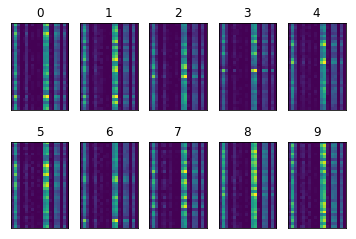

In [9]:
features=model_feature.predict([x_test], batch_size=batch_size)

plt.figure(1)

for number in range(10):
    N=int(1.5*encoding_dim)
    img=np.zeros((N,encoding_dim))

    n0=0
    for n in range(y_test.shape[0]):
        if(y_test_class[n,number]==1 and n0<N):
            img[n0,:]=features[n,:]
            n0+=1

    fig=plt.subplot(2, 5, number+1)
    plt.imshow(img)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.set_title(str(number))
    
    imageio.imwrite("features_number_"+str(number)+"_autoencoder.png",img)

plt.show()

Utilisation des attributs avec un SVM

In [10]:
features_train=model_feature.predict([x_train], batch_size=batch_size)
features_test=model_feature.predict([x_test], batch_size=batch_size)

C_test=[0.001,0.01,0.1,1,10,100,1000]
gamma_test=[0.002,0.02,0.2,2,20,200,2000]

features_train_svm1=features_train[0:5000,:]
y_train_svm1=y_train[0:5000]

features_train_svm2=features_train[5000:10000,:]
y_train_svm2=y_train[5000:10000]

features_train_svm3=features_train[10000:15000]
y_train_svm3=y_train[10000:15000]

acc_max=0
c0=0.001
g0=0.002

for c in C_test:
    for g in gamma_test:
        svc = SVC(kernel="rbf", C=c, gamma=g)
        svc.fit(features_train_svm1, y_train_svm1)
        svc.fit(features_train_svm2, y_train_svm2)
        svc.fit(features_train_svm3, y_train_svm3)
        res_tmp= svc.score(features_test, y_test)
        
        if(100.0*res_tmp>acc_max):
            c0=c
            g0=g
            acc_max=100.0*res_tmp
            print("Précision pour C="+str(c0)+" et gamma="+str(g0)+": "+str(acc_max)+"%")

svc = SVC(kernel="rbf", C=c0, gamma=g0)
svc.fit(features_train,y_train)
score_final=svc.score(features_test, y_test)

print("-------------------------------------------------------------------------------------------")

print("Précision finale avec un SVM à noyau gaussien (C="+str(c0)+", gamma="+str(g0)+"): "+str(100.0*score_final)+"%")

Précision pour C=0.001 et gamma=0.002: 11.35%
Précision pour C=0.01 et gamma=0.002: 14.649999999999999%
Précision pour C=0.01 et gamma=0.02: 21.029999999999998%
Précision pour C=0.1 et gamma=0.002: 26.91%
Précision pour C=0.1 et gamma=0.02: 51.38%
Précision pour C=0.1 et gamma=0.2: 63.18%
Précision pour C=1 et gamma=0.02: 68.53%
Précision pour C=1 et gamma=0.2: 72.76%
Précision pour C=10 et gamma=0.02: 72.91%
Précision pour C=10 et gamma=0.2: 73.6%
Précision pour C=100 et gamma=0.02: 75.28%
Précision pour C=1000 et gamma=0.02: 76.1%
-------------------------------------------------------------------------------------------
Précision finale avec un SVM à noyau gaussien (C=1000, gamma=0.02): 83.54%


# Résultats du modèle de classification

In [11]:
model_feature=load_model("model_feature_classif.h5")
model_classif=load_model("model_classif_classif.h5")
model_autoencoder=load_model("model_autoencoder_classif.h5")

loss_and_metrics_autoencoder = model_autoencoder.evaluate([x_test], [x_test], batch_size=batch_size)
print(loss_and_metrics_autoencoder)
print("---")
loss_and_metrics_classif = model_classif.evaluate([x_test], [y_test_class], batch_size=batch_size)
print(loss_and_metrics_classif)

/homes/c18deche/miniconda3/lib/python3.6/site-packages/keras/models.py:291: UserWarning: Error in loading the saved optimizer state. As a result, your model is starting with a freshly initialized optimizer.
  warnings.warn('Error in loading the saved optimizer '


10000/10000 [==============================] - 0s 29us/step
[0.25313712760806084, 0.4772627881169319, 0.3983051010966301]
---
10000/10000 [==============================] - 0s 34us/step
[0.16142563285538927, 0.015987778035923838, 0.007267162190673844, 0.9535000032186508]


/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 14.450211524963379]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 6.415660381317139]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 10.272473335266113]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: Conversion from float64 to uint8, range [0.0, 9.192705154418945]
  'range [{2}, {3}]'.format(dtype_str, out_type.__name__, mi, ma))
/homes/c18deche/miniconda3/lib/python3.6/site-packages/imageio/core/util.py:104: UserWarning: 

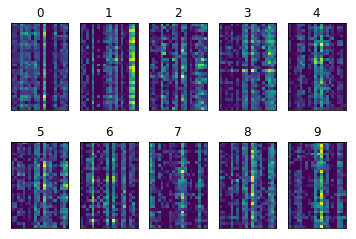

In [12]:
features=model_feature.predict([x_test], batch_size=batch_size)

plt.figure(1)

for number in range(10):
    N=int(1.5*encoding_dim)
    img=np.zeros((N,encoding_dim))

    n0=0
    for n in range(y_test.shape[0]):
        if(y_test_class[n,number]==1 and n0<N):
            img[n0,:]=features[n,:]
            n0+=1

    fig=plt.subplot(2, 5, number+1)
    plt.imshow(img)
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.set_title(str(number))
    
    imageio.imwrite("features_number_"+str(number)+"_classif.png",img)

plt.show()

Utilisation des attributs avec un SVM

In [13]:
features_train=model_feature.predict([x_train], batch_size=batch_size)
features_test=model_feature.predict([x_test], batch_size=batch_size)

C_test=[0.001,0.01,0.1,1,10,100,1000]
gamma_test=[0.002,0.02,0.2,2,20,200,2000]

features_train_svm1=features_train[0:5000,:]
y_train_svm1=y_train[0:5000]

features_train_svm2=features_train[5000:10000,:]
y_train_svm2=y_train[5000:10000]

features_train_svm3=features_train[10000:15000]
y_train_svm3=y_train[10000:15000]

acc_max=0
c0=0.001
g0=0.002

for c in C_test:
    for g in gamma_test:
        svc = SVC(kernel="rbf", C=c, gamma=g)
        svc.fit(features_train_svm1, y_train_svm1)
        svc.fit(features_train_svm2, y_train_svm2)
        svc.fit(features_train_svm3, y_train_svm3)
        res_tmp= svc.score(features_test, y_test)
        
        if(100.0*res_tmp>acc_max):
            c0=c
            g0=g
            acc_max=100.0*res_tmp
            print("Précision pour C="+str(c0)+" et gamma="+str(g0)+": "+str(acc_max)+"%")

svc = SVC(kernel="rbf", C=c0, gamma=g0)
svc.fit(features_train,y_train)
score_final=svc.score(features_test, y_test)

print("-------------------------------------------------------------------------------------------")

print("Précision finale avec un SVM à noyau gaussien (C="+str(c0)+", gamma="+str(g0)+"): "+str(100.0*score_final)+"%")

Précision pour C=0.001 et gamma=0.002: 11.35%
Précision pour C=0.01 et gamma=0.002: 34.19%
Précision pour C=0.01 et gamma=0.02: 84.38%
Précision pour C=0.1 et gamma=0.002: 90.28%
Précision pour C=0.1 et gamma=0.02: 94.07%
Précision pour C=1 et gamma=0.002: 94.34%
Précision pour C=1 et gamma=0.02: 95.41%
-------------------------------------------------------------------------------------------
Précision finale avec un SVM à noyau gaussien (C=1, gamma=0.02): 96.61999999999999%
